## XGBoost
This notebook fits an XGBoost model to the Scania Trucks Air Pressure System (APS) predictive maintenance dataset, obtained from [UCI's data repository](https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks). 

In the Logistic Regression & Naive Bayes notebooks, grid searches were used for hyperparameter tuning. However, significantly more computational resources are required to fit an XGBoost model. Thus, this notebook will use a Genetic Algorithm in lieu of grid search or Bayesian Optimization.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from xgboost import XGBClassifier

from sklearn.metrics import auc, roc_curve, precision_recall_curve, make_scorer, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.core.mixed import MixedVariableGA
from pymoo.core.variable import Real, Integer, Choice, Binary

sns.set()

### Load Data

In [43]:
df_train = pd.read_csv(r'./data/aps_failure_training_set_data_only.csv')

In [44]:
# df --> X_train & y_train
X_train = df_train.drop('class', axis=1)
y_train = df_train['class'].replace({'pos': 1.0, 'neg': 0.0})

In [45]:
y_train.value_counts()

0.0    59000
1.0     1000
Name: class, dtype: int64

### XGBoost & pymoo

In [11]:
def calc_misclassification_cost(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    return 10*fp + 500*fn


misclassification_cost = make_scorer(
    calc_misclassification_cost,
    greater_is_better=False,
    needs_proba=False,
    needs_threshold=False
)

In [64]:
class HyperparameterTuningXGB(ElementwiseProblem):

    def __init__(self, vars, X_train, y_train, file_path):       
        super().__init__(vars=vars, n_obj=1)

        self.X_train = X_train
        self.y_train = y_train
        self.file_path = file_path
        self.i = 1


    def _evaluate(self, x, out, *args, **kwargs):

        xgb = XGBClassifier(
            n_estimators=100,
            objective='binary:logistic',
            booster='gbtree',
            verbosity=0,
            random_state=1,
            max_depth=x['max_depth'], 
            gamma=x['gamma'], 
            min_child_weight=x['min_child_weight'], 
            grow_policy=x['grow_policy'], 
            learning_rate=x['learning_rate'], 
            subsample=x['subsample'], 
            colsample_bytree=x['colsample_bytree'], 
            reg_alpha=x['reg_alpha'], 
            scale_pos_weight=x['scale_pos_weight'], 
        )

        scores = cross_val_score(xgb, cv=5, X=self.X_train, y=self.y_train, scoring=misclassification_cost, n_jobs=-1)
        cv_mean_cost = scores.mean()
        
        self.write_log_file(-cv_mean_cost, x)

        out["F"] = -cv_mean_cost


    def write_log_file(self, cv_mean_cost, params):
        # CSV columns
        cols = ['run_id', 'cv_mean_cost', *sorted(params.keys())]

        # Add misclassification cost to params dict
        params['run_id'] = self.i
        params['cv_mean_cost'] = cv_mean_cost

        # Write to CSV
        if self.i == 1:
            with open(self.file_path, 'w') as f:
                w = csv.DictWriter(f, cols)
                w.writeheader()
                w.writerow(params)

        else:
            with open(self.file_path, 'a') as f:
                w = csv.DictWriter(f, cols)
                w.writerow(params)

        # Increment
        self.i += 1

        # No return value
        pass

In [65]:
vars = {
    "max_depth": Integer(bounds=(2, 100)),
    "gamma": Real(bounds=(0.1, 0.75)),
    "min_child_weight": Integer(bounds=(1, 10)),
    "grow_policy": Choice(options=['depthwise', 'lossguide']),
    "learning_rate": Real(bounds=(0.01, 0.75)),
    "subsample": Real(bounds=(0.5, 1.0)),
    "colsample_bytree": Real(bounds=(0.5, 1.0)),
    "reg_alpha": Real(bounds=(0.0, 0.05)), 
    "scale_pos_weight": Choice(options=[1, 59]),
}

In [66]:
problem = HyperparameterTuningXGB(vars, X_train, y_train, r'./logs/log_xgb_ga.csv')

algorithm = MixedVariableGA(pop=50)

res = minimize(problem,
               algorithm,
               termination=('n_eval', 500),
               seed=1,
               save_history=True,
               verbose=True)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       50 |  2.166452E+04 |  8.852000E+03
     2 |      100 |  1.723368E+04 |  8.852000E+03
     3 |      150 |  1.572004E+04 |  8.620000E+03
     4 |      200 |  1.460456E+04 |  8.328000E+03
     5 |      250 |  1.287324E+04 |  8.218000E+03
     6 |      300 |  1.118212E+04 |  7.944000E+03
     7 |      350 |  9.840320E+03 |  7.944000E+03
     8 |      400 |  8.902720E+03 |  7.624000E+03
     9 |      450 |  8.599840E+03 |  7.624000E+03
    10 |      500 |  8.380400E+03 |  7.624000E+03
Best solution found: 
X = {'max_depth': 2, 'min_child_weight': 2, 'gamma': 0.14672250058344571, 'learning_rate': 0.24814962445178415, 'subsample': 0.6911207278390701, 'colsample_bytree': 0.8385764077975448, 'reg_alpha': 0.031090311587020775, 'grow_policy': 'lossguide', 'scale_pos_weight': 59, 'run_id': 358, 'cv_mean_cost': 7624.0}
F = [7624.]


In [67]:
def xgb_evaluate(params, X, y):

    xgb = XGBClassifier(
        n_estimators=100,
        objective='binary:logistic',
        booster='gbtree',
        verbosity=0,
        random_state=1,
        max_depth=params['max_depth'], 
        gamma=params['gamma'], 
        min_child_weight=params['min_child_weight'], 
        grow_policy=params['grow_policy'], 
        learning_rate=params['learning_rate'], 
        subsample=params['subsample'], 
        colsample_bytree=params['colsample_bytree'], 
        reg_alpha=params['reg_alpha'], 
        scale_pos_weight=params['scale_pos_weight'], 
    )

    scores = cross_val_score(xgb, cv=5, X=X, y=y, scoring=misclassification_cost, n_jobs=-1)
    cv_mean_cost = scores.mean()
    
    return xgb, cv_mean_cost

In [69]:
clf, score = xgb_evaluate(res.X, X_train, y_train)

print(score)

-7624.0


In [71]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8385764077975448, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.14672250058344571, gpu_id=-1, grow_policy='lossguide',
              importance_type=None, interaction_constraints='',
              learning_rate=0.24814962445178415, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=2, max_leaves=0,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0.031090311587020775, reg_lambda=1, ...)

### Best Estimator - Plots & Post-Processing

In [86]:
def plot_roc_auc(y_true, y_pred, model_name, file_path, figsize=(10, 8)):
    # Create figure
    fig = plt.figure(figsize=figsize)

    # Calculate ROC Curve & AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    area = auc(fpr, tpr)
    plt.title('ROC Curve | %s | AUC = %0.5f' % (model_name, area))
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')

    # Save & close plot
    plt.plot(fpr, tpr)
    fig.savefig(file_path)
    plt.close(fig)

    return area


def plot_precision_recall_auc(y_true, y_pred, model_name, file_path, figsize=(10, 8)):
    # Create figure
    fig = plt.figure(figsize=figsize)

    # Calculate ROC Curve & AUC
    pr, rc, thresholds = precision_recall_curve(y_true, y_pred)
    area = auc(rc, pr)
    plt.title('Precision-Recall Curve | %s | AUC = %0.5f' % (model_name, area))
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    # Save & close plot
    plt.plot(rc, pr)
    fig.savefig(file_path)
    plt.close(fig)

    return area

probs = clf.predict_proba(X_train)

plot_roc_auc(y_train, probs[:, 1], 'XGBoost', r'./results/xgb_roc.jpg');
plot_precision_recall_auc(y_train, probs[:, 1], 'XGBoost', r'./results/xgb_pr.jpg');

![image](./results/xgb_roc.jpg)
![image](./results/xgb_pr.jpg)

### Misclassification Cost on Test Data

In [73]:
df_test = pd.read_csv(r'./data/aps_failure_test_set_data_only.csv')

X_test = df_test.drop('class', axis=1)
y_test = df_test['class'].replace({'pos': 1.0, 'neg': 0.0})
y_pred = clf.predict(X_test)

print('Misclassification Cost on Test Data: %i' % calc_misclassification_cost(y_test, y_pred))

Misclassification Cost on Test Data: 13250


In [74]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('Number of Type 1 Faults: %i' % fp)
print('Number of Type 2 Faults: %i' % fn)

Number of Type 1 Faults: 375
Number of Type 2 Faults: 19


* The XGBoost model performed better than the Random Forest model with regards to the average Cross Validation score, but performed slightly worse on the Test Dataset.

* This is a sign that the model is overfitting to the training data.

* Most importantly, the XGBoost performed worse than the Random Forest with respects to Type 2 Faults (19 - XGBoost vs. 22 - Random Forest). It had less Type 1 Faults but the additional Type 2 Faults caused its overall Misclassification Cost to be higher.

* To improve upon this, a secondary hyperparameter search could be done to aid with generalization; e.g. search over a wider range of regularization parameters (alpha, lambda) to aid with overfitting. As shown in the plot below, only alpha was tuned and over a range of 0.0 to 0.05

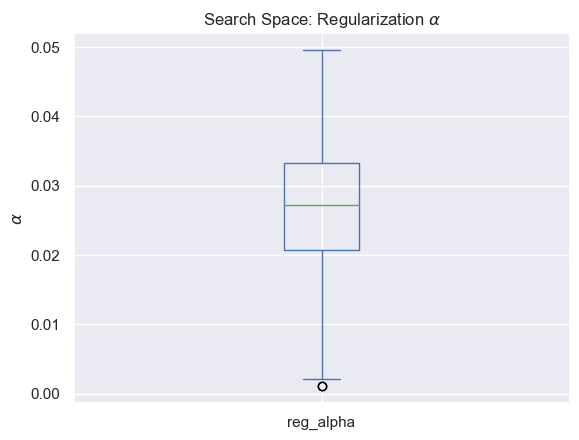

In [87]:
df = pd.read_csv(r'./logs/log_xgb_ga.csv')
df['reg_alpha'].plot(kind='box', title=r'Search Space: Regularization $\alpha$', ylabel=r'$\alpha$');